In [2]:
import pandas as pd
import re
import unicodedata


# Baca file
with open('ind.txt', 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')

# Proses setiap baris untuk memisahkan pasangan kalimat
pairs = []
for l in lines:
    # Hapus atribusi CC-BY 2.0
    if '\tCC-BY 2.0' in l:
        l = l.replace('\tCC-BY 2.0', '')
    parts = l.split('\t')
    if len(parts) == 2:
        pairs.append(parts)

# Buat DataFrame
df = pd.DataFrame(pairs, columns=['english', 'indonesian'])
print("Jumlah pasangan kalimat:", len(df))
print(df.head())

Jumlah pasangan kalimat: 14881
  english                                         indonesian
0     Hi.  Hai. (France) Attribution: tatoeba.org #538123...
1    Run!  Lari! (France) Attribution: tatoeba.org #90632...
2    Run.  Lari! (France) Attribution: tatoeba.org #40089...
3    Who?  Siapa? (France) Attribution: tatoeba.org #2083...
4    Wow!  Wow! (France) Attribution: tatoeba.org #52027 ...


In [3]:
def normalize_string(s):
    # Ubah unicode ke ASCII
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    # Hapus spasi berlebih, ubah ke huruf kecil
    s = re.sub(r"([.!?])", r" \1", s.lower().strip())
    # Hapus karakter selain huruf dan tanda baca dasar
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s.strip()

df['english_cleaned'] = df['english'].apply(normalize_string)
df['indonesian_cleaned'] = df['indonesian'].apply(normalize_string)

print("\nContoh data setelah dibersihkan:")
print(df[['english_cleaned', 'indonesian_cleaned']].head())


Contoh data setelah dibersihkan:
  english_cleaned                                 indonesian_cleaned
0            hi .   hai . france attribution tatoeba .org cm pacific
1           run !  lari ! france attribution tatoeba .org papabea...
2           run .  lari ! france attribution tatoeba .org jsakura...
3           who ?  siapa ? france attribution tatoeba .org ck dba...
4           wow !  wow ! france attribution tatoeba .org zifre db...


In [4]:
# Gabungkan semua data untuk melatih model SentencePiece
with open('corpus.txt', 'w', encoding='utf-8') as f:
    for sent in df['english_cleaned']:
        f.write(sent + '\n')
    for sent in df['indonesian_cleaned']:
        f.write(sent + '\n')

In [5]:
import sentencepiece as spm

# Parameter untuk model SentencePiece
vocab_size = 8000  # Ukuran vocabulary awal
model_prefix = 'spm_model'
model_type = 'bpe' # Bisa juga 'unigram'

# Perintah untuk melatih model
spm.SentencePieceTrainer.train(
    f'--input=corpus.txt --model_prefix={model_prefix} '
    f'--vocab_size={vocab_size} --model_type={model_type} '
    f'--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3'
)

# Muat model yang sudah dilatih
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

# Contoh tokenisasi
english_sample = df['english_cleaned'].iloc[0]
indonesian_sample = df['indonesian_cleaned'].iloc[0]

print("Kalimat Inggris:", english_sample)
print("Token ID:", sp.encode_as_ids(english_sample))
print("Subwords:", sp.encode_as_pieces(english_sample))

Kalimat Inggris: hi .
Token ID: [1354, 6]
Subwords: ['▁hi', '▁.']


In [6]:
from sklearn.model_selection import train_test_split

# Pisahkan data menjadi train (80%) dan temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Pisahkan data temp menjadi validation (10%) dan test (10%)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Ukuran data latih: {len(train_df)}")
print(f"Ukuran data validasi: {len(valid_df)}")
print(f"Ukuran data uji: {len(test_df)}")

# Simpan ke file untuk digunakan nanti
train_df.to_csv('train.csv', index=False)
valid_df.to_csv('valid.csv', index=False)
test_df.to_csv('test.csv', index=False)

Ukuran data latih: 11904
Ukuran data validasi: 1488
Ukuran data uji: 1489


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math

# Pastikan menggunakan GPU jika tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src len, batch size, emb dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        return outputs, hidden

# --- Attention ---
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src len, hid dim]
        # encoder_outputs = [batch size, src len, hid dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src len, hid dim]
        attention = self.v(energy).squeeze(2)
        # attention = [batch size, src len]
        return F.softmax(attention, dim=1)

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(hid_dim + emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim * 2 + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [n layers, batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb dim]
        a = self.attention(hidden[-1], encoder_outputs)
        # a = [batch size, src len]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src len, hid dim]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, hid dim]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, hid dim]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, hid dim + emb dim]
        output, hidden = self.rnn(rnn_input, hidden)
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden

# --- Seq2Seq Model ---
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [8]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class TranslationDataset(Dataset):
    def __init__(self, df, sp_model):
        self.df = df
        self.sp = sp_model
        self.bos_id = self.sp.bos_id()
        self.eos_id = self.sp.eos_id()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        src_text = self.df.iloc[idx]['indonesian_cleaned']
        trg_text = self.df.iloc[idx]['english_cleaned']
        src_tensor = torch.tensor([self.bos_id] + self.sp.encode_as_ids(src_text) + [self.eos_id])
        trg_tensor = torch.tensor([self.bos_id] + self.sp.encode_as_ids(trg_text) + [self.eos_id])
        return src_tensor, trg_tensor

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    # Pad sequences dengan padding_value=0 (PAD_ID)
    src_padded = pad_sequence(src_batch, padding_value=0, batch_first=False)
    trg_padded = pad_sequence(trg_batch, padding_value=0, batch_first=False)
    return src_padded, trg_padded

# Buat instance Dataset dan DataLoader
train_dataset = TranslationDataset(train_df, sp)
valid_dataset = TranslationDataset(valid_df, sp)

BATCH_SIZE = 64
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [11]:
from tqdm import tqdm

In [12]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

# Inisialisasi bobot
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0) # Abaikan padding token

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    # Bungkus iterator dengan tqdm
    progress_bar = tqdm(iterator, desc='Training', leave=False)

    for i, (src, trg) in enumerate(progress_bar):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        # Update progress bar dengan nilai loss saat ini
        progress_bar.set_postfix({'loss': loss.item()})

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    # Bungkus iterator dengan tqdm
    progress_bar = tqdm(iterator, desc='Validating', leave=False)

    with torch.no_grad():
        for i, (src, trg) in enumerate(progress_bar):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0) # Turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

    return epoch_loss / len(iterator)
# Proses training hingga konvergen
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 's2s-attention-model.pt')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Train Loss: 5.036 | Val. Loss: 4.647


Epoch: 02 | Train Loss: 4.130 | Val. Loss: 4.229


Epoch: 03 | Train Loss: 3.583 | Val. Loss: 3.915


Epoch: 04 | Train Loss: 3.105 | Val. Loss: 3.629


Epoch: 05 | Train Loss: 2.640 | Val. Loss: 3.524


Epoch: 06 | Train Loss: 2.243 | Val. Loss: 3.394


Epoch: 07 | Train Loss: 1.927 | Val. Loss: 3.337


Epoch: 08 | Train Loss: 1.634 | Val. Loss: 3.397


Epoch: 09 | Train Loss: 1.429 | Val. Loss: 3.439


Epoch: 10 | Train Loss: 1.259 | Val. Loss: 3.464


In [13]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, x, target):
        # x: [batch_size * seq_len, vocab_size]
        # target: [batch_size * seq_len]
        assert x.size(1) == self.cls
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.cls - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return self.criterion(F.log_softmax(x, dim=1), true_dist)

# Ganti criterion lama dengan yang baru saat melatih Transformer
# criterion = LabelSmoothingLoss(classes=OUTPUT_DIM, padding_idx=0, smoothing=0.1)

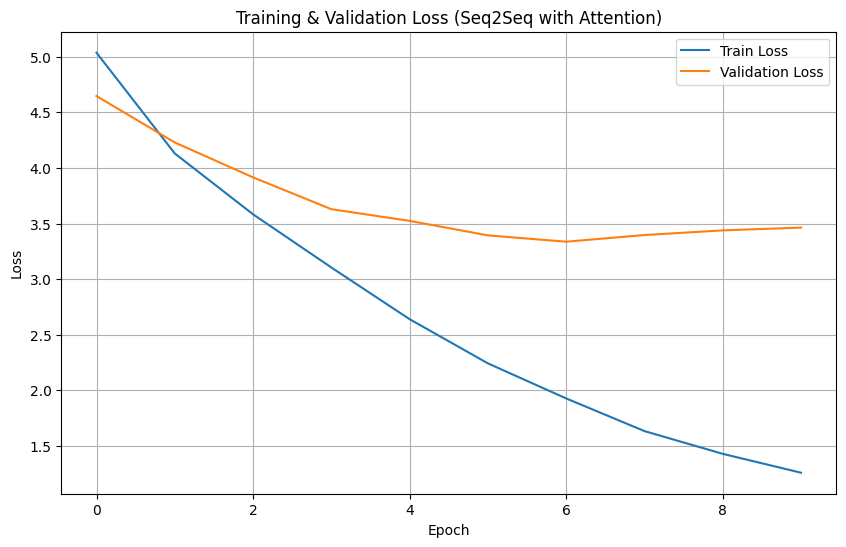

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training & Validation Loss (Seq2Seq with Attention)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def translate_sentence(sentence, sp_model, model, device, max_len=50):
    model.eval()
    # Tokenisasi dan tambahkan token BOS/EOS
    tokens = [sp_model.bos_id()] + sp_model.encode_as_ids(sentence) + [sp_model.eos_id()]
    src_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device)

    # (Implementasi logic untuk Seq2Seq dan Transformer berbeda)
    # Untuk Seq2Seq:
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [sp_model.bos_id()]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == sp_model.eos_id():
            break

    trg_tokens = sp_model.decode(trg_indexes)
    return trg_tokens

# Hitung BLEU score pada data test
from sacrebleu.metrics import BLEU

bleu = BLEU()
targets = []
predictions_s2s = []
# predictions_transformer = [] # Jika sudah melatih transformer

# Muat model terbaik
model.load_state_dict(torch.load('s2s-attention-model.pt'))

for index, row in test_df.iterrows():
    src = row['indonesian_cleaned']
    trg = row['english_cleaned']

    prediction = translate_sentence(src, sp, model, device)

    predictions_s2s.append(prediction)
    targets.append([trg]) # sacrebleu butuh referensi dalam list

bleu_score = bleu.corpus_score(predictions_s2s, targets)
print(f"SacreBLEU Score (Seq2Seq Attention): {bleu_score.score}")

SacreBLEU Score (Seq2Seq Attention): 21.3643503198117


In [18]:
# Tampilkan beberapa contoh
for i in range(5):
    print(f"Sumber (ID): {test_df['indonesian_cleaned'].iloc[i]}")
    print(f"Target (EN): {targets[i][0]}")
    print(f"Prediksi (S2S): {predictions_s2s[i]}\n")


Sumber (ID): dilarang melewati garis putih . france attribution tatoeba .org sundown hagni
Target (EN): crossing the white line is forbidden .
Prediksi (S2S): the forbidden is forbidden to the white .

Sumber (ID): aku akan mengambilnya kembali dari tom . france attribution tatoeba .org ck bilmanda
Target (EN): i will get it back from tom .
Prediksi (S2S): i ll going to from tom .

Sumber (ID): spesies burung itu dikatakan terancam punah . france attribution tatoeba .org cm pacific
Target (EN): that species of bird is said to be in danger of dying out .
Prediksi (S2S): the united nationsony was success independ independ .

Sumber (ID): dia dijatuhi hukuman mati . france attribution tatoeba .org ck pacific
Target (EN): he was sentenced to death .
Prediksi (S2S): he was condemged to death .

Sumber (ID): aku akan bertanggung jawab penuh . france attribution tatoeba .org ck bilmanda
Target (EN): i m going to take full responsibility .
Prediksi (S2S): i m going to europe .

